# Finding recommended songs in Melodist

# Table of Contents

- [**1. Import Package**](#import_package) <br>
- [**2. Load Data**](#load_data) <br>
    - [2.1. Songs](#load_data_song) <br>
    - [2.2. Tags](#load_data_tags) <br>
- [**3. Preprocessing**](#prep) <br>
    - [3.3. Unknown Songs](#prep_unknown) <br>
    - [3.2. Playlist](#prep_playlist) <br>
- [**4. Create Model**](#model)
- [**5. Training**](#training)
- [**6. Analysis**](#analysis)
- [**7. Generate Recommendation**](#generate)
- [**8. Evaluation**](#eval)

# Import Package <a class='anchor' id='import_package'></a>

In [4]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")

# Modeling
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
# from spherecluster import SphericalKMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy import stats

# Additional
import math
import random
import itertools
import multiprocessing
from tqdm import tqdm
from time import time
import logging
import pickle

# Load Data <a class='anchor' id='load_data'></a>

In [5]:
folder_path = "../Data/"

## Songs <a class='anchor' id='load_data_song'></a>

In [82]:
songs = pd.read_csv(folder_path+"song_hash.txt", sep = '\t', header = None,
                    names = ['song_id', 'title', 'artist'], index_col = 0)
songs['artist - title'] = songs['artist'] + " - " + songs['title']
songs

,title,artist,artist - title
song_id,,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane,Gucci Mane - Gucci Time (w\/ Swizz Beatz)
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross,Rick Ross - Aston Martin Music (w\/ Drake & Ch...
2,Get Back Up (w\/ Chris Brown),T.I.,T.I. - Get Back Up (w\/ Chris Brown)
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher,Usher - Hot Toddy (w\/ Jay-Z & Ester Dean)
4,Whip My Hair,Willow,Willow - Whip My Hair
...,...,...,...
75257,Dearest (I'm So Sorry),Picture Me Broken,Picture Me Broken - Dearest (I'm So Sorry)
75258,USA Today,Alan Jackson,Alan Jackson - USA Today
75259,Superstar,Raul Malo,Raul Malo - Superstar


## Tags <a class='anchor' id='load_data_tags'></a>

In [83]:
def readTXT(filename, start_line=0, sep=None):
    with open(filename) as file:
        return [line.rstrip().split(sep) for line in file.readlines()[start_line:]]

In [84]:
tags = readTXT(folder_path+"tags.txt")
tags[7:12]

[['49', '65', '72', '141', '197'], ['11', '35', '154'], ['#'], ['#'], ['#']]

In [85]:
mapping_tags = dict(readTXT(folder_path+"tag_hash.txt", sep = ', '))
mapping_tags['#'] = "unknown"

In [86]:
song_tags = pd.DataFrame({'tag_names': [list(map(lambda x: mapping_tags.get(x), t)) for t in tags]})
song_tags.index.name = 'song_id'
songs = pd.merge(left = songs, right = song_tags, how = 'left',
                 left_index = True, right_index = True)
songs.index = songs.index.astype('str')
songs.head()

,title,artist,artist - title,tag_names
song_id,,,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane,Gucci Mane - Gucci Time (w\/ Swizz Beatz),[wjlb-fm]
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross,Rick Ross - Aston Martin Music (w\/ Drake & Ch...,"[chill, rnb, loved, hip hop, rap, soft, wjlb-f..."
2,Get Back Up (w\/ Chris Brown),T.I.,T.I. - Get Back Up (w\/ Chris Brown),[wjlb-fm]
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher,Usher - Hot Toddy (w\/ Jay-Z & Ester Dean),"[pop, hip-hop]"
4,Whip My Hair,Willow,Willow - Whip My Hair,"[pop, american, dance, rnb, hip-hop, hip hop, ..."


# Preprocessing <a class='anchor' id='prep'></a>

## Unknown Songs <a class='anchor' id='prep_unknown'></a>

In [87]:
songs[(songs['artist'] == '-') | (songs['title'] == '-')].shape

(1813, 4)

In [88]:
songs[(songs['artist'] == '-') | (songs['title'] == '-')].head(10)

,title,artist,artist - title,tag_names
song_id,,,,
13382,-,-,- - -,[unknown]
16277,-,-,- - -,[unknown]
16343,-,-,- - -,[unknown]
18762,-,-,- - -,[unknown]
18763,-,-,- - -,[unknown]
18764,-,-,- - -,[unknown]
19288,-,-,- - -,[unknown]
19367,-,-,- - -,[unknown]
19420,-,-,- - -,[unknown]


In [89]:
unknown_song = songs[(songs['artist'] == '-') | (songs['title'] == '-')] 
songs = songs[(songs['artist'] != '-') & (songs['title'] != '-')]

In [90]:
unknown_song

,title,artist,artist - title,tag_names
song_id,,,,
13382,-,-,- - -,[unknown]
16277,-,-,- - -,[unknown]
16343,-,-,- - -,[unknown]
18762,-,-,- - -,[unknown]
18763,-,-,- - -,[unknown]
...,...,...,...,...
74101,-,-,- - -,[unknown]
74105,-,-,- - -,[unknown]
74803,-,-,- - -,[unknown]


In [91]:
songs

,title,artist,artist - title,tag_names
song_id,,,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane,Gucci Mane - Gucci Time (w\/ Swizz Beatz),[wjlb-fm]
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross,Rick Ross - Aston Martin Music (w\/ Drake & Ch...,"[chill, rnb, loved, hip hop, rap, soft, wjlb-f..."
2,Get Back Up (w\/ Chris Brown),T.I.,T.I. - Get Back Up (w\/ Chris Brown),[wjlb-fm]
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher,Usher - Hot Toddy (w\/ Jay-Z & Ester Dean),"[pop, hip-hop]"
4,Whip My Hair,Willow,Willow - Whip My Hair,"[pop, american, dance, rnb, hip-hop, hip hop, ..."
...,...,...,...,...
75257,Dearest (I'm So Sorry),Picture Me Broken,Picture Me Broken - Dearest (I'm So Sorry),[unknown]
75258,USA Today,Alan Jackson,Alan Jackson - USA Today,"[country, heard on pandora, classic country]"
75259,Superstar,Raul Malo,Raul Malo - Superstar,[unknown]


## Playlist <a class='anchor' id='prep_playlist'></a>

In [213]:
# dimulai dari line 2 karena line 0 dan 1 aneh
playlist = readTXT(folder_path+"train.txt", start_line = 2) + readTXT(folder_path+"test.txt", start_line = 2)
print(f"Playlist Count: {len(playlist)}")

Playlist Count: 15910


In [214]:
for i in range(0, 3):
    print("-------------------------")
    print(f"Playlist Idx. {i}: {len(playlist[i])} Songs")
    print("-------------------------")
    print(playlist[i])

-------------------------
Playlist Idx. 0: 97 Songs
-------------------------
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43']
-------------------------
Playlist Idx. 1: 205 Songs
-------------------------
['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '1

In [215]:
# REMOVE UNKOWN SONG
playlist_wo_unknown = [[song_id for song_id in p if song_id not in unknown_song.index]
                       for p in playlist]

# REMOVE ZERO OR ONE SONG PLAYLIST
clean_playlist = [p for p in playlist_wo_unknown if len(p) > 1]
print(f"Playlist Count After Cleansing: {len(clean_playlist)}")

Playlist Count After Cleansing: 15842


In [216]:
# REMOVE SONG THAT DOES NOT EXIST IN PLAYLIST

unique_song = set(np.concatenate(clean_playlist))
unexist_song = set(songs.index) - unique_song
songs = songs.drop(unexist_song, axis=0)

In [217]:
songs.shape

(73448, 4)

# Create Model <a class='anchor' id='model'></a>

In [283]:
model_path = "../Model/"
# playlist_train, playlist_test = train_test_split(clean_playlist, test_size = 1000,
#                                                  shuffle = True, random_state = 123)

playlist_train = clean_playlist.copy()

In [290]:
# SONG2VEC

model = Word2Vec(
    vector_size = 256,
    window = 10,
    min_count = 1,
    sg = 0,
    negative = 20,
    workers = multiprocessing.cpu_count()-1)
print(model)

Word2Vec<vocab=0, vector_size=256, alpha=0.025>


# Training <a class='anchor' id='training'></a>

In [291]:
model.build_vocab(playlist)

In [292]:
model.train(playlist,
            total_examples = model.corpus_count,
            epochs = 500,
            compute_loss = True) 

(1427120333, 1428203000)

In [293]:
model.save(model_path+"song2vec_2.model")

# Vector Analysis <a class='anchor' id='analysis'></a>

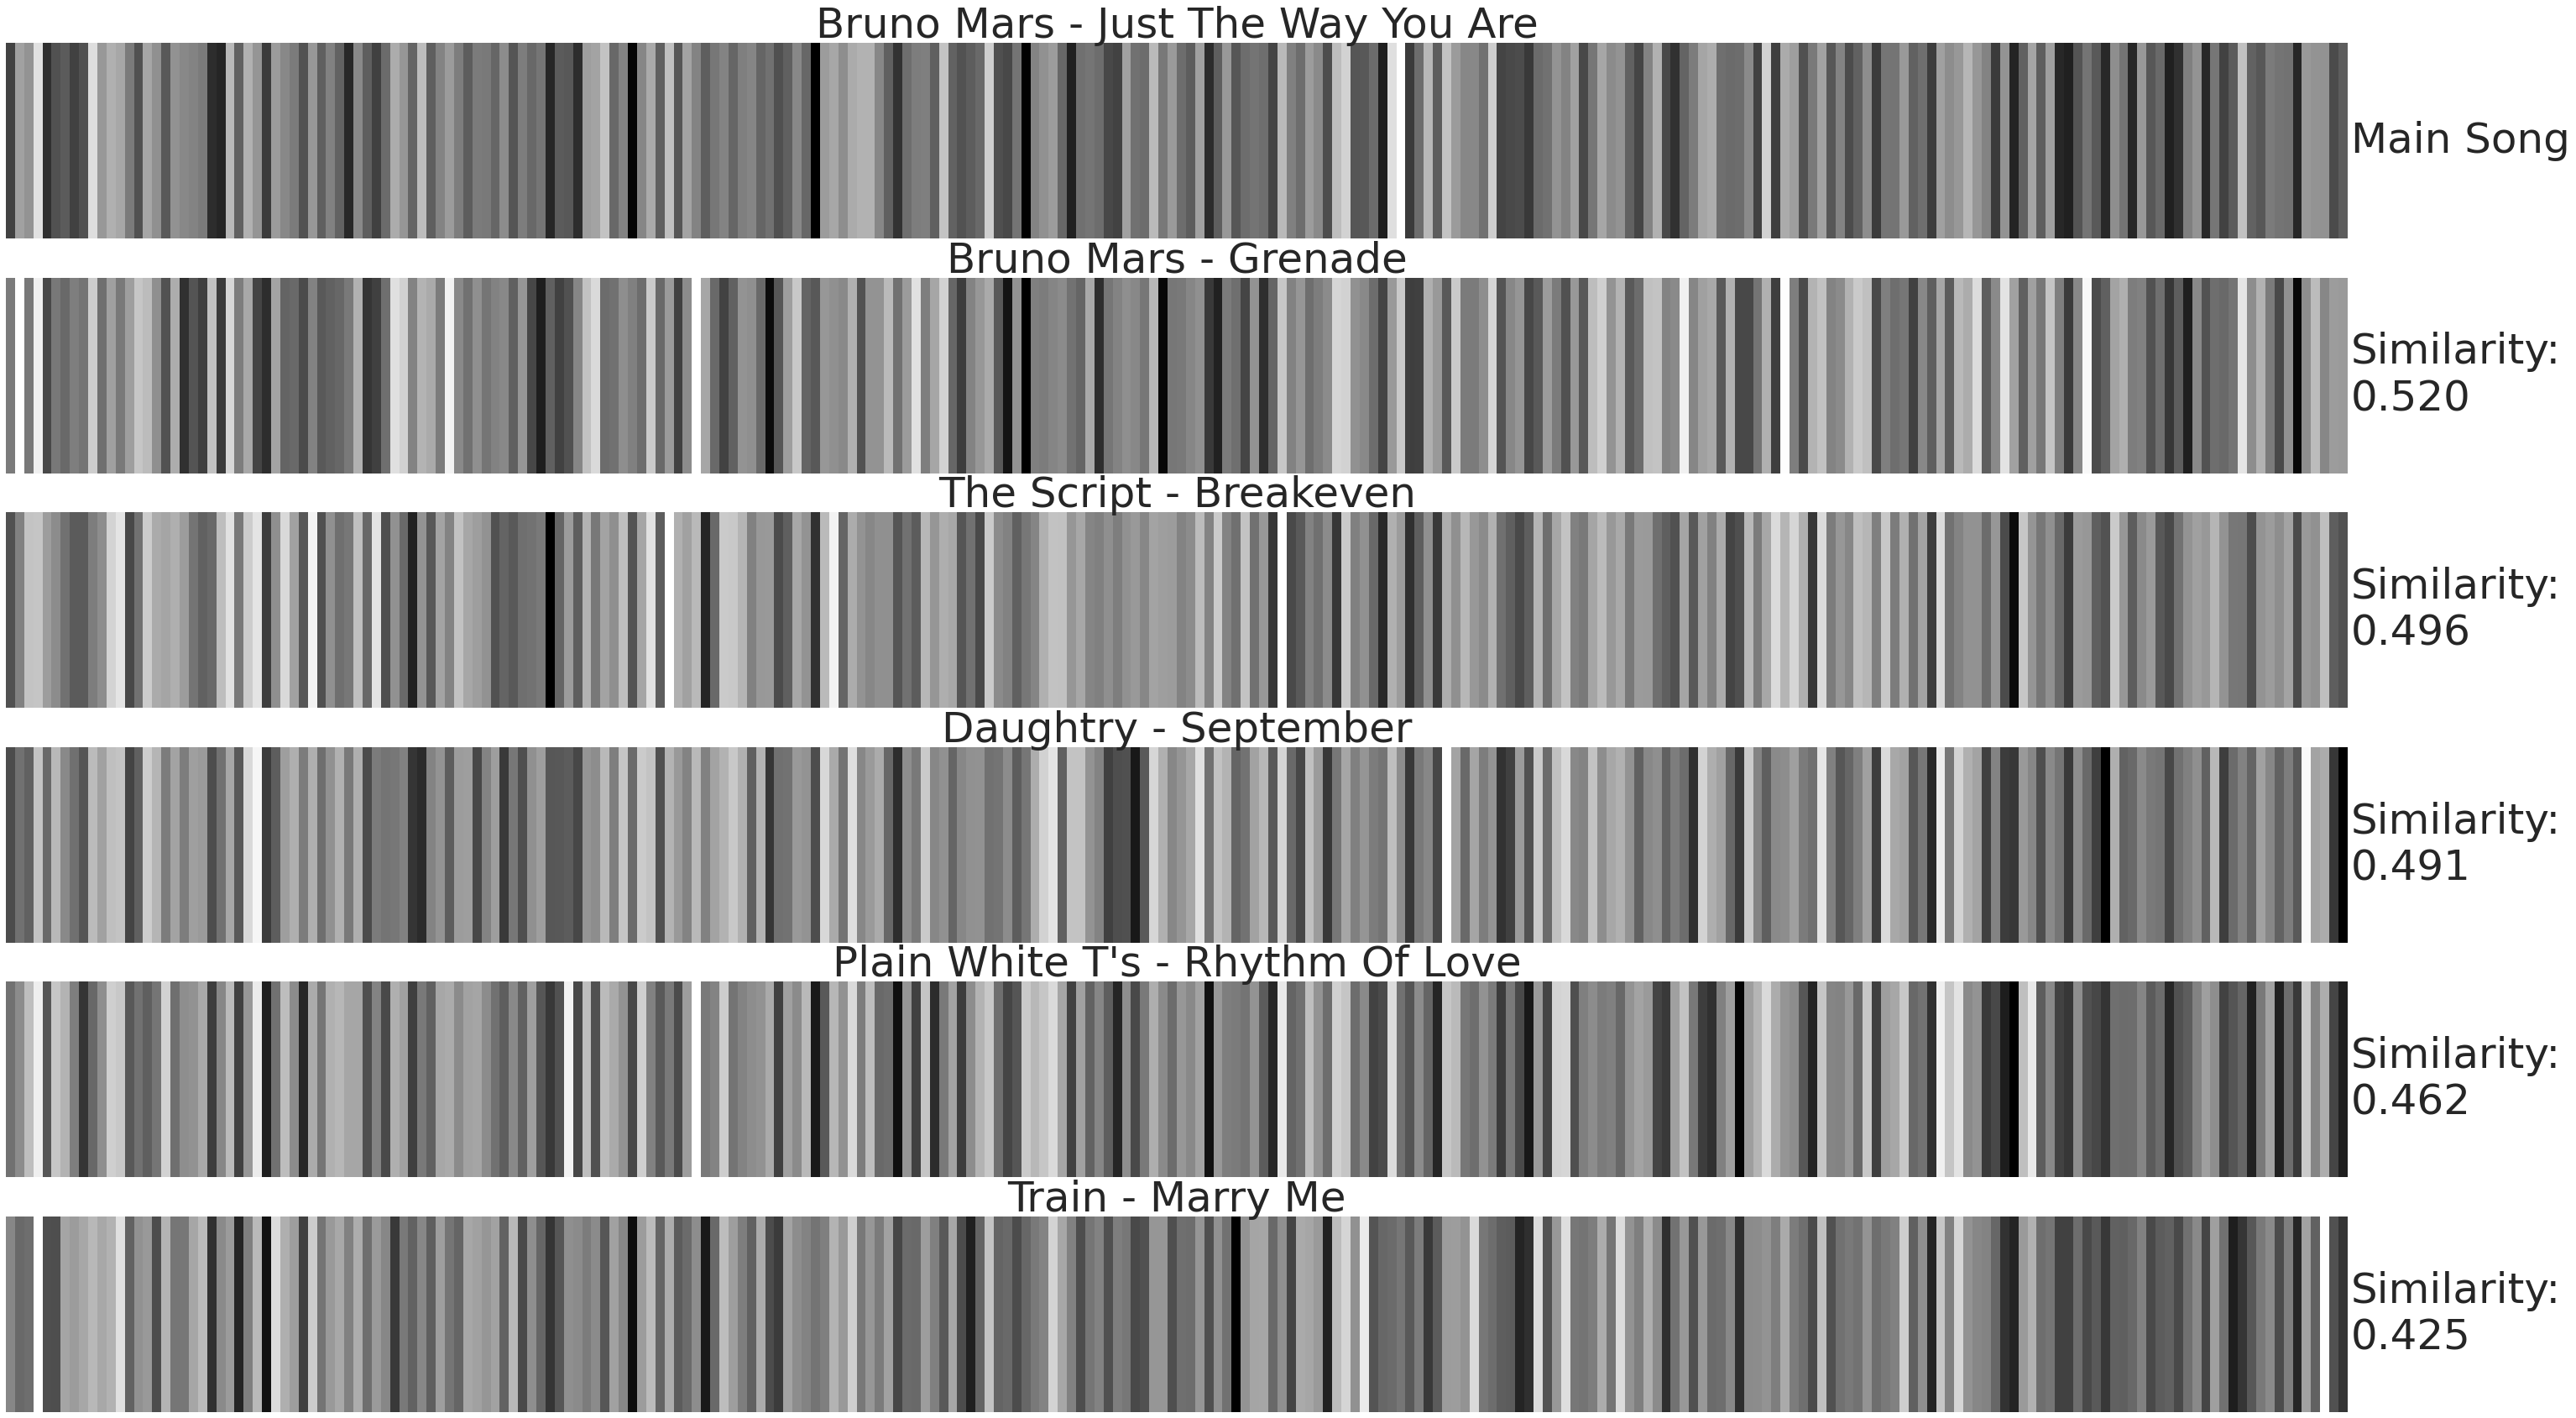

In [299]:
fig, axes = plt.subplots(6, 1, figsize = (50, 30))

slug = '60'
song_id_list = [(slug, "Main Song"), *[t for t in model.wv.most_similar(slug)[:5]]] 

for ax, (song_id, sim) in zip(axes.flat, song_id_list):
    ax.imshow([model.wv[song_id]], cmap = "binary", aspect = "auto")
    ax.set_title(songs.loc[song_id, "artist - title"], fontsize = 50)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"Similarity:\n{sim:.3f}" if sim != song_id_list[0][1] else sim,
                  rotation = "horizontal", ha = "left", va = "center", fontsize = 50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# Generate Recommendation <a class='anchor' id='generate'></a>

In [295]:
def similarSongsByVector(vec, n = 10, by_name = True):
    # extract most similar songs for the input vector
    similar_songs = model.wv.similar_by_vector(vec, topn = n)
    
    # extract name and similarity score of the similar products
    if by_name:
        similar_songs = [(songs.loc[song_id, "artist - title"], sim)
                              for song_id, sim in similar_songs]
    
    return similar_songs

In [296]:
def print_recommended_songs(idx, n):
    print("============================")
    print("SONGS INPUT", songs.loc[str(idx), "artist - title"])
    print("============================")
    print()
    print("============================")
    print(f"TOP {n} RECOMMENDED SONGS")
    print("============================")
    for song, sim in similarSongsByVector(model.wv[str(idx)], n):
        print(f"[Similarity: {sim:.3f}] {song}")
    print("============================")

In [308]:
print_recommended_songs(60,11)

SONGS INPUT Bruno Mars - Just The Way You Are

TOP 11 RECOMMENDED SONGS
[Similarity: 1.000] Bruno Mars - Just The Way You Are
[Similarity: 0.520] Bruno Mars - Grenade
[Similarity: 0.496] The Script - Breakeven
[Similarity: 0.491] Daughtry - September
[Similarity: 0.462] Plain White T's - Rhythm Of Love
[Similarity: 0.425] Train - Marry Me
[Similarity: 0.422] Train - Hey, Soul Sister
[Similarity: 0.416] Daughtry - Life After You
[Similarity: 0.406] Katy Perry - Firework
[Similarity: 0.385] Natasha Bedingfield - Unwritten
[Similarity: 0.380] Katy Perry - Teenage Dream


In [300]:
generate_recommendation = []

for idx in tqdm(songs.index):
    recommended_songs = similarSongsByVector(model.wv[idx], n = 11, by_name=False)
    recommended_songs = [np.concatenate([[idx],i]).tolist() for i in recommended_songs]
    generate_recommendation.append(recommended_songs)

generate_recommendation = pd.DataFrame(np.concatenate(generate_recommendation), columns=['id_x','id_y','value'])
generate_recommendation = generate_recommendation[generate_recommendation['id_x']!=generate_recommendation['id_y']]

100%|██████████| 73448/73448 [04:40<00:00, 261.44it/s]


In [303]:
generate_recommendation[generate_recommendation['id_x'] == '0']

,id_x,id_y,value
1,0,18,0.442859023809433
2,0,216,0.4103654623031616
3,0,6714,0.39119428396224976
4,0,20620,0.3817773759365082
5,0,6713,0.379373699426651
6,0,20108,0.36906373500823975
7,0,6851,0.35256892442703247
8,0,6762,0.34641316533088684
9,0,5759,0.3413185775279999
10,0,20624,0.340579092502594


In [304]:
generate_recommendation.to_csv('../results_2.csv',index=False)

# Evaluation <a class='anchor' id='eval'></a>

Submission will evaluate model AHR (Average Hit Rate) of your model's Top 10 recommended similar song output for each input song in all given playlist that contain numbers of song.

For example, if you run a song titled "Gucci Time", the song will be checked whether it is contained in playlist #1 that contains 17 different songs. If "Gucci Time" is listed, then your model will check whether any of your Top 10 similar song output match with the rest of 16 songs in playlist. If there's another match between songs in playlist #1 and your Top 10 similar song output, for example 2 songs, that will make the AHR of your Top 10 similar song output for "Gucci Time" in playlist #1 is 3/17 or 17.6%. Whenever "Gucci Time" is not listed in certain playlist, the AHR cannot be measured or null for that playlist

The AHR calculation performed to all song, and then is averaged to get the total AHR, with the nulls exluded.

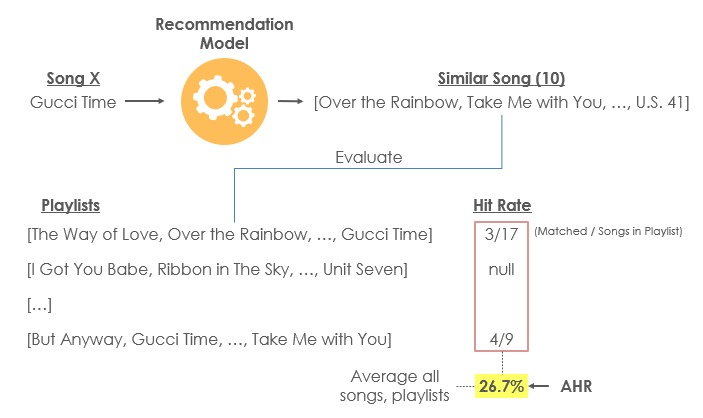

In [309]:
def ahr(song_id, playlist_test, n_songs):
    hit_rate = 0
    target_playlist = [i for i in playlist_test if str(song_id) in i]
    for target in target_playlist:
        recommended_songs = similarSongsByVector(model.wv[str(song_id)], n = n_songs+1, by_name = False)
        songs_id = list(zip(*recommended_songs))[0]
        hit = (len(set(songs_id) and set(target)))/(len(target))
        hit = 0 if hit < 0 else hit
        hit_rate += hit
    return hit_rate/len(target_playlist)

In [310]:
random.seed(42)
song_to_test = random.sample(songs.index.tolist(),1000)

final_ahr = 0

for idx in tqdm(song_to_test):
    ahr_score = ahr(idx,playlist,10)
    final_ahr += ahr_score

print(final_ahr/len(songs.index))

100%|██████████| 1000/1000 [03:21<00:00,  4.95it/s]

0.011916461695319193


# Reference <a class='anchor' id='ref'></a>

https://github.com/tomytjandra/song2vec-music-recommender/blob/master/song2vec.ipynb